# Learner

## Imports

In [ ]:
from datasets import load_dataset, load_dataset_builder

import torch
from torch.optim import SGD
import torchvision.transforms.functional as TF
import random
import numpy as np
from operator import attrgetter
from copy import copy
from contextlib import contextmanager

from fastprogress.fastprogress import master_bar, progress_bar
from minai.datasets import inplace, collate_dict
from torcheval.metrics import MulticlassAccuracy, Mean
from minai.conv import to_device
from functools import partial
import math


from matplotlib import pyplot as plt
from torch.optim.lr_scheduler import ExponentialLR

## Set Seed

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [ ]:
set_seed(42)

## Load dataset

In [ ]:
x, y = 'image', 'label'
dsd = load_dataset("fashion_mnist")

In [ ]:
dsb = load_dataset_builder("fashion_mnist")

In [ ]:
featy = dsd['train'].features[y].names; featy

['T - shirt / top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
dsd['train'][0][x]

In [ ]:
featy[dsd['train'][0][y]]

'Ankle boot'

In [ ]:
type(dsd['train'][0][x])

PIL.PngImagePlugin.PngImageFile

## Transform

In [ ]:
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [ ]:
bs = 1024
tds = dsd.with_transform(transformi)

## DataLoaders

In [ ]:
class DataLoaders:
    def __init__(self, *dls):
        self.train, self.valid = dls[:2]
        
    @classmethod
    def from_dd(cls, tds, batch_size):
        return cls(*[DataLoader(ds, batch_size, collate_fn=collate_dict(ds)) for ds in tds.values()])

In [ ]:
dls = DataLoaders.from_dd(tds, bs)

In [ ]:
xb, yb = next(iter(dls.train))

In [ ]:
xb.shape, yb.shape

(torch.Size([1024, 784]), torch.Size([1024]))

In [ ]:
batch = (xb, yb)

## Model

In [ ]:
def get_model(m=784, nh=50):
    return nn.Sequential(
        nn.Linear(m, nh),
        nn.ReLU(), 
        nn.Linear(nh, 10)
    )

In [ ]:
model = get_model(); model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
model(xb).shape

torch.Size([1024, 10])

In [ ]:
F.softmax(model(xb), dim=-1).argmax(-1)

tensor([1, 6, 6,  ..., 6, 6, 6])

## Learner

In [ ]:
class Learner:
    def __init__(self, model, dls, lr, loss_func, opt_func = SGD):
        fc.store_attr()
    
    def one_batch(self):
        self.batch = to_device(self.batch)
        self.preds = self.model(self.batch[0])
        self.loss = self.loss_func(self.preds, self.batch[1])
        n = len(self.batch[0])
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        
        self.losses.append(self.loss * n)
        self.accs.append((self.preds.argmax(-1) == self.batch[1]).float().sum())
        self.ns.append(n)
        
    
    def log(self):
        n = sum(self.ns)
        accuracy = sum(self.accs).item() / n
        loss = sum(self.losses).item() / n
        step = "Training" if self.model.training else "Validation"
        print(self.epoch, step, loss, accuracy)
        
    def one_epoch(self, train):
        self.accs, self.losses, self.ns = [], [], []
        self.model.train(train)
        dl = dls.train if self.model.training else dls.valid
        for self.batch in dl:
            self.one_batch()
        self.log()
        
        
    def fit(self, n_epochs):
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self.n_epochs = n_epochs
        self.epochs = range(self.n_epochs)
        for self.epoch in self.epochs:
            self.one_epoch(True)
            self.one_epoch(False)

In [ ]:
learn  = Learner(get_model(), dls, 0.2, F.cross_entropy)

In [ ]:
learn.fit(1)

0 Training 1.1514001302083334 0.6056666666666667
0 Validation 0.88968134765625 0.6819


## Callback

In [ ]:
class Callback():
    order = 0
    _fwd = 'model', 'opt', 'batch'
    
    def __getattr__(self, name):
        if name in self._fwd: return getattr(self.learn, name)
        raise AttributeError(name)
    
    def __setattr__(self, name, val):
        if name in self._fwd: warn(f"You are trying to set {name} in self.learn")
        super().__setattr__(name, val)
    
    @property
    def training(self): return self.model.training

In [ ]:
class CompleteCB(Callback): # Counts the number of batches elapsed in the training loop
    def before_fit(self): self.count = 0
    def after_batch(self): self.count += 1
    def after_fit(self): print(f"Completed {self.count} batches")

In [ ]:
def run_cbs(cbs, method_nm):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None)
        if method: method()

In [ ]:
cbs = [CompleteCB()]
run_cbs(cbs, 'before_fit')
run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'after_fit')

Completed 1 batches


### Exception

In [ ]:
class CancelFitException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass

In [ ]:
class Learner:
    def __init__(self, model, dls, lr, loss_func, opt_func=SGD, cbs=[]):
        fc.store_attr()
        for cb in self.cbs: cb.learn = self
    
    def one_epoch(self, train):
        self.model.train(train)
        self.dl = dls.train if self.model.training else dls.valid
        try:
            self.callback('before_epoch')
            for self.batch in self.dl:
                try:
                    self.callback('before_batch')
                    self.preds = self.model(self.batch[0])
                    self.loss = self.loss_func(self.preds, self.batch[1])
                    if self.model.training:
                        self.loss.backward()
                        self.opt.step()
                        self.opt.zero_grad()
                except CancelBatchException: pass
                finally: self.callback('after_batch')
        except CancelEpochException: pass
        finally: self.callback('after_epoch')
                
    def fit(self, n_epochs):
        try:
            self.opt = self.opt_func(self.model.parameters(), self.lr)
            self.n_epochs = n_epochs
            self.epochs = range(self.n_epochs)
            self.callback('before_fit')
            for self.epoch in self.epochs:
                self.one_epoch(True)
                self.one_epoch(False)
        except CancelFitException: pass
        finally: self.callback('after_fit')
    
    def callback(self, method_nm): run_cbs(self.cbs, method_nm)

In [ ]:
class DeviceCB(Callback):
    def before_batch(self): self.learn.batch = to_device(self.batch)
    def before_fit(self): self.model.to(def_device)

In [ ]:
learn = Learner(get_model(), dls, 0.2, F.cross_entropy, cbs=[DeviceCB(), CompleteCB()])

In [ ]:
learn.fit(1)

Completed 69 batches


## Metric

In [ ]:
class Metric:
    def __init__(self): self.reset()
    def reset(self): self.vals, self.ns = [], []
    def add(self, inp, targ=None, n=1):
        last = self.calc(inp, targ)
        self.vals.append(last)
        self.ns.append(n)
    
    @property
    def value(self):
        ns = tensor(self.ns)
        return (tensor(self.vals) * ns).sum() / ns.sum()
    
    def calc(self, inp, targ): return inp        

In [ ]:
loss = Metric()

In [ ]:
loss.add(0.9, n=2)
loss.add(0.1, n=3)

In [ ]:
loss.value

tensor(0.42)

In [ ]:
(1.8 + 0.3)/ 5

0.42000000000000004

In [ ]:
loss.reset()

In [ ]:
loss.value

tensor(nan)

In [ ]:
class Accuracy(Metric): 
    def calc(self, inp, targ): return (tensor(inp) == tensor(targ)).float().mean()

In [ ]:
acc = Accuracy()

In [ ]:
acc.add([1, 0, 1, 0], [1, 1, 1, 1])

In [ ]:
acc.value

tensor(0.50)

In [ ]:
acc.add([1, 1, 1, 0], [1, 1, 1, 1])

In [ ]:
acc.value

tensor(0.62)

## TorchEval

In [ ]:
acc = MulticlassAccuracy()

In [ ]:
acc.update(tensor([1, 0, 1, 0]), tensor([1, 1, 1, 1]))

<torcheval.metrics.classification.accuracy.MulticlassAccuracy>

In [ ]:
acc.compute()

tensor(0.50)

In [ ]:
acc.update(tensor([1, 1, 1, 0]), tensor([1, 1, 1, 1]))

<torcheval.metrics.classification.accuracy.MulticlassAccuracy>

In [ ]:
acc.compute()

tensor(0.62)

In [ ]:
loss = Mean()

In [ ]:
loss.update(tensor(0.9), weight=2)

<torcheval.metrics.aggregation.mean.Mean>

In [ ]:
loss.update(tensor(0.1), weight=3)

<torcheval.metrics.aggregation.mean.Mean>

In [ ]:
loss.compute()

tensor(0.42, dtype=torch.float64)

## MetricCB

In [ ]:
class MetricCB(Callback):
    def __init__(self, *m, **ms):
        for o in m: ms[type(o).__name__] = o
        self.metrics = ms
        self.all_metrics = copy(ms)
        self.all_metrics['loss'] = Mean()
    
    def before_fit(self): self.learn.metrics = self
    
    def before_epoch(self): [v.reset() for k, v in self.all_metrics.items()]
    
    def after_batch(self):
        for k, v in self.metrics.items(): v.update(self.learn.preds.argmax(-1), self.learn.batch[1])
        self.all_metrics['loss'].update(self.learn.loss, weight=len(self.learn.batch[0]))
    
    def _log(self, d):
        print(d)
        
    def after_epoch(self):
        d = {k: v.compute().item() for k, v in self.all_metrics.items()}
        d['epoch'] = self.learn.epoch
        d['train'] = self.training
        self._log(d)

In [ ]:
metrics = MetricCB(MulticlassAccuracy())
learn = Learner(get_model(), dls, 0.2, F.cross_entropy, cbs = [DeviceCB(), metrics])

In [ ]:
learn.fit(1)

{'MulticlassAccuracy': 0.6046500205993652, 'loss': 1.1899776596069336, 'epoch': 0, 'train': True}
{'MulticlassAccuracy': 0.7002999782562256, 'loss': 0.8055204406738281, 'epoch': 0, 'train': False}


## ProgressCB

In [ ]:
class ProgressCB(Callback):
    order = MetricCB.order + 1
    
    def __init__(self, plot=False): self.plot = plot
        
    def before_fit(self): 
        self.learn.epochs = self.mbar = master_bar(self.learn.epochs)
        self.learn.metrics._log = self._log
    
    def before_epoch(self): 
        self.learn.dl = progress_bar(self.learn.dl, leave=False, parent=self.mbar)
        self.train_losses = []
    
    def _log(self, d): self.mbar.write(str(d))
         
    def after_batch(self):
        self.learn.dl.comment = f'Loss {self.learn.loss.item(): .3f}'
        if self.plot and self.training and hasattr(self.learn, 'metrics'): 
            self.train_losses.append(self.learn.loss.item())
            self.mbar.update_graph([[fc.L.range(self.train_losses), self.train_losses]])

In [ ]:
learn = Learner(get_model(), dls, 0.2, F.cross_entropy, cbs = [DeviceCB(), metrics, ProgressCB(plot=True)])

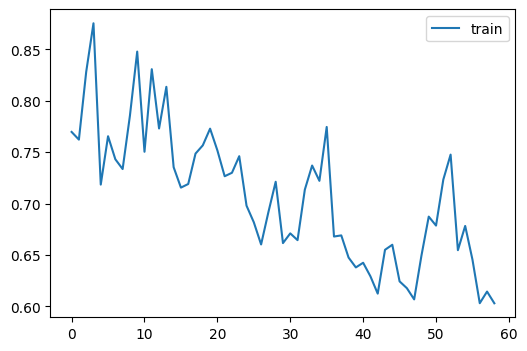

In [ ]:
learn.fit(2)

## TrainCB

In [ ]:
class TrainCB(Callback):
    def predict(self): self.learn.preds = self.learn.model(self.learn.batch[0])
    def get_loss(self): self.learn.loss = self.learn.loss_func(self.learn.preds, self.learn.batch[1])
    def backward(self): self.learn.loss.backward()
    def step(self): self.learn.opt.step()
    def zero_grad(self): self.learn.opt.zero_grad()

In [ ]:
class Learner:
    def __init__(self, model, dls, lr, loss_func, opt_func=SGD, cbs=[]):
        fc.store_attr()
        for cb in self.cbs: cb.learn = self
    
    def one_epoch(self, train):
        self.model.train(train)
        self.dl = dls.train if self.model.training else dls.valid
        try:
            self.callback('before_epoch')
            for self.batch in self.dl:
                try:
                    self.callback('before_batch')
                    self.predict()
                    self.get_loss()
                    if self.model.training:
                        self.backward()
                        self.step()
                        self.zero_grad()
                except CancelBatchException: pass
                finally: self.callback('after_batch')
        except CancelEpochException: pass
        finally: self.callback('after_epoch')
                
    def fit(self, n_epochs):
        try:
            self.opt = self.opt_func(self.model.parameters(), self.lr)
            self.n_epochs = n_epochs
            self.epochs = range(self.n_epochs)
            self.callback('before_fit')
            for self.epoch in self.epochs:
                self.one_epoch(True)
                self.one_epoch(False)
        except CancelFitException: pass
        finally: self.callback('after_fit')
    
    def __getattr__(self, name):
        if name in ['predict', 'get_loss', 'backward', 'step', 'zero_grad']: return partial(self.callback, name)
        raise AttributeError(name)
    
    def callback(self, method_nm): run_cbs(self.cbs, method_nm)

In [ ]:
learn = Learner(get_model(), dls, 0.2, F.cross_entropy, cbs = [DeviceCB(), TrainCB(), metrics, ProgressCB(plot=True)])

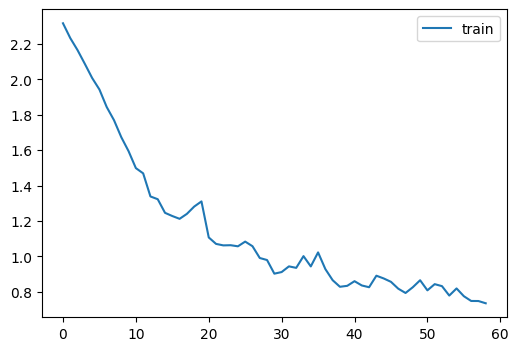

In [ ]:
learn.fit(1)

## Learner
> with context manager

In [ ]:
class Learner:
    def __init__(self, model, dls, lr, loss_func, opt_func=SGD, cbs = []):
        fc.store_attr()
        for cb in self.cbs: cb.learn = self
    
    @contextmanager
    def context_mgr(self, method_nm):
        try:
            self.callback(f'before_{method_nm}')
            yield
        except globals()[f'Cancel{method_nm.title()}Exception']: pass
        finally: self.callback(f'after_{method_nm}')

    
    def one_epoch(self, train):
        self.model.train(train)
        self.dl = dls.train if self.model.training else dls.valid
        with self.context_mgr('epoch'):
            for self.batch in self.dl:
                with self.context_mgr('batch'):
                    self.predict()
                    self.get_loss()
                    if self.model.training:
                        self.backward()
                        self.step()
                        self.zero_grad()
            
        
    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(self.n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        with self.context_mgr('fit'):
            for self.epoch in self.epochs:
                self.one_epoch(True)
                self.one_epoch(False)
    
    def __getattr__(self, name):
        if name in ['predict', 'get_loss', 'backward', 'step', 'zero_grad']: return partial(self.callback, name)
        raise AttributeError(name)
    
    def callback(self, name): run_cbs(self.cbs, name)

In [ ]:
class TrainLearner(Learner):
    def predict(self): self.preds = self.model(self.batch[0])
    def get_loss(self): self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

In [ ]:
class MomentumLearner(TrainLearner):
    def __init__(self, model, dls, lr, loss_func, opt_func, cbs=[], mom=0.8):
        self.mom = mom
        super().__init__(model, dls, lr, loss_func, opt_func, cbs=cbs)
    
    def zero_grad(self):
        with torch.no_grad():
            for p in self.model.parameters(): p.grad *= self.mom

In [ ]:
metrics = MetricCB(MulticlassAccuracy())
learn = MomentumLearner(get_model(), dls, 0.2, F.cross_entropy, SGD, cbs=[DeviceCB(), metrics, ProgressCB(plot=True)])

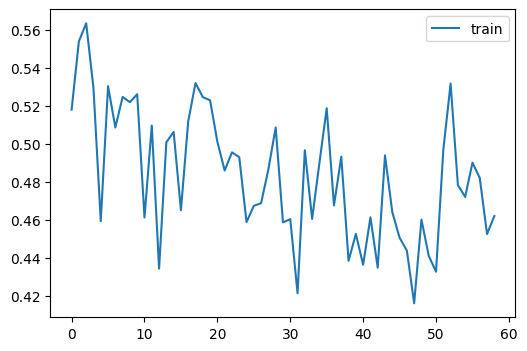

In [ ]:
learn.fit(2)

## LR Finder Callback

In [ ]:
op = SGD(model.parameters(), lr=0.2)

In [ ]:
op.param_groups[0]['lr']

0.2

In [ ]:
class LRFinderCB(Callback):
    def __init__(self, gamma=1.3):
        fc.store_attr()
    
    def before_fit(self):
        self.lrs, self.losses = [], []
        self.min = math.inf
    
    def after_batch(self):
        if not self.learn.model.training: raise CancelEpochException()
        self.losses.append(self.learn.loss.item())
        self.lrs.append(self.learn.opt.param_groups[0]['lr'])
        if self.learn.loss < self.min: self.min = self.learn.loss
        if self.learn.loss > self.min * 3: raise CancelFitException()
        for p in self.learn.opt.param_groups: p['lr'] *= self.gamma
    
    def after_fit(self):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')

In [ ]:
metrics = MetricCB(MulticlassAccuracy())
learn = MomentumLearner(get_model(), dls, 0.2, F.cross_entropy, SGD, cbs=[DeviceCB(), LRFinderCB()])

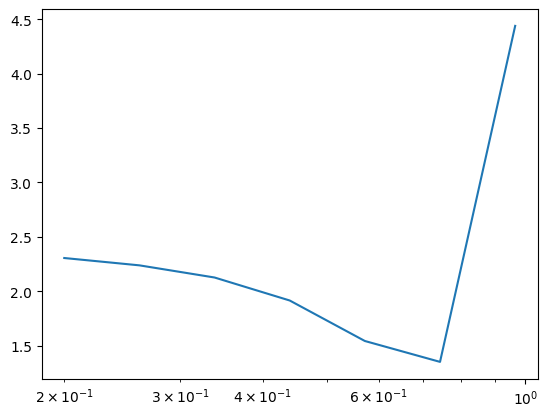

In [ ]:
learn.fit(1)

## LR Finder Callback
> With scheduler

In [ ]:
class LRFinderCB(Callback):
    def __init__(self, gamma=1.3):
        fc.store_attr()
    
    def before_fit(self):
        self.lrs, self.losses = [], []
        self.min = math.inf
        self.sched = ExponentialLR(self.learn.opt, gamma=self.gamma)
    
    def after_batch(self):
        if not self.learn.model.training: raise CancelEpochException()
        self.losses.append(self.learn.loss.item())
        self.lrs.append(self.learn.opt.param_groups[0]['lr'])
        if self.learn.loss < self.min: self.min = self.learn.loss
        if self.learn.loss > self.min * 3: raise CancelFitException()
        self.sched.step()
    
    def after_fit(self):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')

In [ ]:
learn = MomentumLearner(get_model(), dls, 0.2, F.cross_entropy, SGD, cbs=[DeviceCB(), LRFinderCB()])

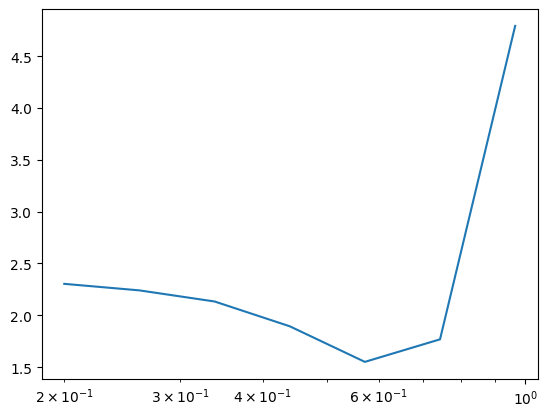

In [ ]:
learn.fit(1)

In [ ]:
metrics = MetricCB(MulticlassAccuracy())
learn = MomentumLearner(get_model(), dls, 0.5, F.cross_entropy, SGD, cbs=[DeviceCB(), metrics, ProgressCB(plot=True)])

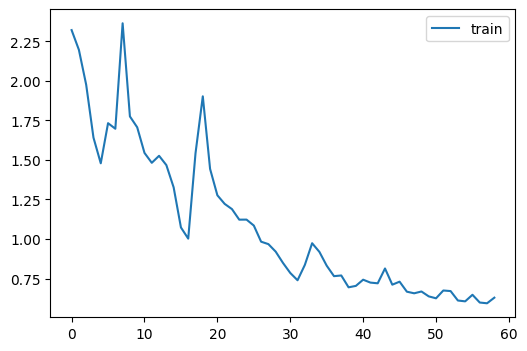

In [ ]:
learn.fit(1)